# Comparação dos valores medidos e simulados de Ks

In [2]:
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import Infiltrometro, ALL_FUNCTIONS, nse, points_distance

from shapely.geometry import Point
from xgboost import XGBRegressor
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import QuantileTransformer

In [3]:
run_ml = True
run_math = True

all_functions = {
    "WMssc": ALL_FUNCTIONS["WMssc"],
    "COSBY": ALL_FUNCTIONS["COSBY"],
    "ROssc": ALL_FUNCTIONS["ROssc"],
    "JULIA": ALL_FUNCTIONS["JULIA"],
    "Puckett": ALL_FUNCTIONS["Puckett"],
    "DanePuckett": ALL_FUNCTIONS["DanePuckett"],
    "Saxton":ALL_FUNCTIONS["Saxton"],
}

In [4]:
infil = pd.read_excel(r"D:\Mestrado\Trabalho Final\Dados\Levantamento em Campo\Compiled.xlsx", sheet_name="Infiltracao")
infil = Infiltrometro(infil)

[ True  True  True  True  True  True  True  True  True False False False
 False False False False False False False False False]


d:\Mestrado\Trabalho Final\Codigos\utils\infiltracao\infiltrometro.py:156: OptimizeWarning: Covariance of the parameters could not be estimated
  (c1, c2), covariance = curve_fit(self._equation_infiltration, t, I)


In [5]:
# K  = infil.K()  # Este valor de K é o K para -2cm de poropressão.
df_Ks:pd.DataFrame = infil.Ks() # Ks é a condutividade Hidráulica Saturada.

len(df_Ks)

Cálculos utilizando C1


84

In [6]:
alfa = df_Ks["alfa"].values
n = df_Ks["n"].values
K = df_Ks["K"].values
Ks:np.ndarray = df_Ks["Ks"].values

In [8]:
np.log10(Ks)

array([-1.46596208, -0.55525226, -2.2350189 , -2.03855274, -2.17013597,
       -2.02632217, -2.48566236, -0.95416924, -1.85642553, -0.82841021,
       -0.4266023 , -1.89898735, -0.71974423,  0.18430805, -1.39196159,
       -1.6545845 , -1.26278567, -1.2787104 , -1.96106971, -0.84467989,
       -1.50315996, -2.10584681, -1.1940097 , -0.53195954, -2.16998306,
       -0.95625013, -1.13717743, -1.39673202, -0.96221006, -1.30593823,
       -0.07100298, -0.80486295, -1.79208057, -1.66209199, -1.86906673,
       -2.03904585, -1.89606044, -1.45377108, -0.93120005, -1.66809009,
       -1.74857482, -2.26964915, -1.942176  , -2.72241184, -1.48716493,
       -1.62260776, -2.33747136, -2.55841129, -1.33104406, -1.30137371,
       -0.85745113, -1.30615029, -2.52924849, -2.04021386, -2.82298596,
       -1.81077972, -2.05595172, -0.74921466, -2.18408246, -1.82167633,
       -0.74925746, -1.14468365, -1.72731092, -1.72207546, -1.65628864,
       -2.44129729, -1.72429263, -2.57963999, -1.8610767 , -2.22

In [25]:
def quantile_mapping(sim, obs):
    """Aplica Quantile Mapping (QM) de simulado -> observado"""
    # Ajusta distribuições separadas
    qm_sim = QuantileTransformer(output_distribution="uniform", n_quantiles=min(100, sim.size))
    qm_obs = QuantileTransformer(output_distribution="uniform", n_quantiles=min(100, obs.size))
    
    # Treina cada um na sua série
    qm_sim.fit(sim.reshape(-1, 1))
    qm_obs.fit(obs.reshape(-1, 1))
    
    # Leva simulado para espaço uniforme
    u = qm_sim.transform(sim.reshape(-1, 1))
    
    # Reprojeta no espaço do observado
    sim_corr = qm_obs.inverse_transform(u)
    return sim_corr.flatten()

In [26]:
# Cálculo da distância entre os pontos

# Método 1
initial_point=infil.infiltrations[infil.infiltrations["Ponto"] == "P21"].index.values[0]
df_Ks["distancia_media"] = points_distance(infil.infiltrations, initial_point)

# Método 2
# points = infil.infiltrations.apply(lambda row: Point(row["Lon"], row["Lat"]), axis=1).values
# distances = np.zeros((len(points), len(points)))
# for i in range(len(points)):
#     for j in range(len(points)):
#         distances[i, j] = points[i].distance(points[j])

# # Distancia média entre pontos
# mask = ~np.eye(distances.shape[0], dtype=bool)
# sem_diag = distances[mask].reshape(distances.shape[0], -1)
# medias = sem_diag.mean(axis=1)
# df_Ks["distancia_media"] = medias

df_Ks = df_Ks.sort_values(by="distancia_media", ascending=False)
df_Ks

,Ponto,Ks,K,Kr,θr,θs,n,alfa,Se,l,distancia_media
37,P84,0.035175,0.004594,0.130601,0.117554,0.430325,1.31,0.019,0.996765,0.5,84
26,P63,0.072916,0.009062,0.124284,0.099473,0.395562,1.48,0.059,0.986652,0.5,83
38,P87,0.117166,0.014562,0.124284,0.091702,0.385133,1.48,0.059,0.986652,0.5,82
53,P115,0.009116,0.001133,0.124284,0.090167,0.387950,1.48,0.059,0.986652,0.5,81
44,P97,0.032571,0.004048,0.124284,0.102963,0.396321,1.48,0.059,0.986652,0.5,80
...,...,...,...,...,...,...,...,...,...,...,...
1,P04,0.278450,0.009209,0.033072,0.069378,0.380130,1.89,0.075,0.987206,0.5,5
50,P106,0.138851,0.004592,0.033072,0.078173,0.380183,1.89,0.075,0.987206,0.5,4
28,P69-A,0.109091,0.013558,0.124284,0.095406,0.369795,1.48,0.059,0.986652,0.5,3
80,P156,0.904869,0.046819,0.051741,0.093184,0.414113,1.56,0.036,0.994143,0.5,2


In [27]:
KSS:dict[str, dict[str, np.ndarray]] = {}

pontos_CV = df_Ks["Ponto"].values

sand = infil.infiltrations["Sand"].values
silt = infil.infiltrations["Silt"].values
clay = infil.infiltrations["Clay"].values

mask_3  = df_Ks["Ponto"].isin(pontos_CV[0:3])
mask_5  = df_Ks["Ponto"].isin(pontos_CV[0:5])
mask_15 = df_Ks["Ponto"].isin(pontos_CV[0:15])
mask_50 = df_Ks["Ponto"].isin(pontos_CV[0:50])

y = np.log10(Ks.astype(np.float64))

for key, value in all_functions.items():
    KSS[key] = {}
    KSS[key]["CVS"] = {}

    kss:np.ndarray = np.log10(value(sand, silt, clay))

    for i in range(1, len(pontos_CV)+1):
        KSS[key]["CVS"][f"CV_{i}"] = {}

        mask = df_Ks["Ponto"].isin(pontos_CV[0:i])
        obs = np.log10(df_Ks[mask]["Ks"].values)
        kss_cv = quantile_mapping(kss, obs)

        KSS[key]["CVS"][f"CV_{i}"]["KSS"] = kss_cv
        KSS[key]["CVS"][f"CV_{i}"]["NSE"] = nse(kss_cv, y, y.mean())
        KSS[key]["CVS"][f"CV_{i}"]["RMSE"] = root_mean_squared_error(y, kss_cv)

    # Usando 3 pontos de calibração
    obs = np.log10(df_Ks[mask_3]["Ks"].values)
    KSS[key][key + "_CV_3"] = quantile_mapping(kss, obs)

    # Usando 5 pontos
    obs = np.log10(df_Ks[mask_5]["Ks"].values)
    KSS[key][key + "_CV_5"] = quantile_mapping(kss, obs)

    # Usando 15 pontos
    obs = np.log10(df_Ks[mask_15]["Ks"].values)
    KSS[key][key + "_CV_15"] = quantile_mapping(kss, obs)

    # Usando 50 pontos
    obs = np.log10(df_Ks[mask_50]["Ks"].values)
    KSS[key][key + "_CV_50"] = quantile_mapping(kss, obs)

    # Usando Todos os pontos
    obs = np.log10(df_Ks["Ks"].values)
    KSS[key][key + "_CV_All"] = quantile_mapping(kss, obs)

    KSS[key][key] = kss

KSS.keys()

A função proposta por Saxton não funciona corretamente


dict_keys(['WMssc', 'COSBY', 'ROssc', 'JULIA', 'Puckett', 'DanePuckett', 'Saxton'])

### Gerando funções com os próprios dados que possuo

In [28]:
# Seed para permitir reprodutibilidade dos valores pseudo-aleatórios
seed = 42

# Definir uma seed para reprodutibilidade
rng = np.random.default_rng(seed)

# Porcentagens de Treino e Teste
train_percent = 50
test_percent  = 50

# Indices de treino e teste
n_train = int(len(Ks)*train_percent/100)
n_teste = len(Ks) - n_train

idxs = np.arange(len(Ks))
idx_train = rng.choice(idxs, size=n_train, replace=False)
idx_test = np.setdiff1d(idxs, idx_train)

X = np.stack([sand, silt, clay], axis=1) # type: ignore
y = np.log10(Ks.astype(np.float64))

X_train = X[idx_train]
X_teste = X[idx_test]

y_train = y[idx_train]
y_teste = y[idx_test]

print("X Treino: ", X_train)
print("X Teste: ", X_teste)
print("y Treino: ", y_train)
print("y Teste: ", y_teste)

X Treino:  [[30. 31. 39.]
 [32. 38. 30.]
 [31. 50. 19.]
 [28. 30. 42.]
 [25. 40. 35.]
 [47. 10. 43.]
 [44. 31. 25.]
 [31. 26. 43.]
 [40. 24. 36.]
 [15. 41. 44.]
 [27. 40. 33.]
 [29. 34. 37.]
 [50. 33. 17.]
 [34. 39. 27.]
 [38. 33. 29.]
 [59. 18. 23.]
 [53. 28. 19.]
 [63. 22. 15.]
 [48.  6. 46.]
 [58. 26. 16.]
 [63. 18. 19.]
 [71. 17. 12.]
 [44. 38. 18.]
 [53. 13. 34.]
 [68.  4. 28.]
 [44. 29. 27.]
 [28. 26. 46.]
 [28. 37. 35.]
 [43. 18. 39.]
 [54.  7. 39.]
 [89.  2.  9.]
 [23. 34. 43.]
 [49. 10. 41.]
 [49. 28. 23.]
 [23. 69.  8.]
 [52. 27. 21.]
 [15. 51. 34.]
 [62. 27. 11.]
 [41. 32. 27.]
 [55. 20. 25.]
 [30. 42. 28.]
 [53. 39.  8.]]
X Teste:  [[50.  9. 41.]
 [68. 19. 13.]
 [11. 45. 44.]
 [53.  4. 43.]
 [48.  6. 46.]
 [75. 13. 12.]
 [55. 32. 13.]
 [60. 15. 25.]
 [46. 15. 39.]
 [42. 43. 15.]
 [50. 25. 25.]
 [61. 17. 22.]
 [39. 24. 37.]
 [57. 21. 22.]
 [33. 58.  9.]
 [49. 25. 26.]
 [74.  1. 25.]
 [40. 24. 36.]
 [41. 24. 35.]
 [27. 35. 38.]
 [31. 31. 38.]
 [57. 21. 22.]
 [49. 23. 28.]
 [1

### ML Models
---

In [29]:
if run_ml:
    KSS["ML"] = {}
if run_math:
    KSS["Ajuste"] = {}

In [30]:
if run_ml:
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    train_rf = rf.predict(X_train)
    pred_rf = rf.predict(X_teste)
    serie_rf = rf.predict(X)

    KSS["ML"]["Rf"] = serie_rf

In [31]:
if run_ml:
    # XGBoost
    xgb = XGBRegressor()
    xgb.fit(X_train, y_train)
    train_xgb = xgb.predict(X_train)
    pred_xgb = xgb.predict(X_teste)
    serie_xgb = xgb.predict(X)

    KSS["ML"]["XGB"] = serie_xgb

In [32]:
if run_math:
    # Linear
    lin = LinearRegression()
    lin.fit(X_train, y_train)
    train_lin = lin.predict(X_train)
    pred_lin = lin.predict(X_teste)
    serie_lin = lin.predict(X)

    a, b, c = lin.coef_
    d = lin.intercept_

    print(f"Ajustado: log10(K) = {a:.4f}*Sand + {b:.4f}*Silt + {c:.4f}*Clay + {d:.4f}")

    KSS["Ajuste"]["Lin"] = serie_lin

Ajustado: log10(K) = 0.0220*Sand + 0.0112*Silt + -0.0332*Clay + -1.7668


In [33]:
if run_math:# Exponencial
    def exponencial(X, a, b, c, d):
        sand, silt, clay = X[:, 0], X[:, 1], X[:, 2]
        return np.exp(a * sand + b * silt + c * clay + d)

    popt, pcov = curve_fit(exponencial, X_train, np.pow(10, y_train))

    a, b, c, d = popt
    print(f"Ajustado: Ks = exp({a:.4f}*Sand + {b:.4f}*Silt + {c:.4f}*Clay + {d:.4f})")

    serie_exp = exponencial(X, *popt)
    KSS["Ajuste"]["Exp"] = np.log10(serie_exp)

Ajustado: Ks = exp(-22.2243*Sand + -22.2465*Silt + -22.4328*Clay + 2224.7909)

In [34]:
if run_math:
    # Potencial
    def potencial(X, a, b, c, d, e):
        sand, silt, clay = X[:, 0], X[:, 1], X[:, 2]

        t1 = a * sand + b * silt + c * clay + d
        return np.pow(e, t1)

    popt, pcov = curve_fit(potencial, X_train, np.pow(10, y_train))

    a, b, c, d, e = popt
    print(f"Ajustado: Ks = {e:.4f}^({a:.4f}*Sand + {b:.4f}*Silt + {c:.4f}*Clay + {d:.4f})")

    serie_pot = potencial(X, *popt)
    KSS["Ajuste"]["Pot"] = np.log10(serie_pot)

Ajustado: Ks = 0.9911^(-2.6629*Sand + -0.1617*Silt + 20.7462*Clay + 0.7510)


In [35]:
if run_math:
    # Multi
    def multi(X, a, b, c, d):
        sand, silt, clay = X[:, 0], X[:, 1], X[:, 2]
        
        t1=a * sand + b * silt + c * clay

        return  d*t1

    popt, pcov = curve_fit(multi, X_train, np.pow(10, y_train))

    a, b, c, d = popt
    print(f"Ajustado: Ks = {d:.4f}*({a:.4f}*Sand + {b:.4f}*Silt + {c:.4f}*Clay)")

    serie_multi = multi(X, *popt)
    KSS["Ajuste"]["Multi"] = np.log10(serie_multi)

Ajustado: Ks = -0.0255*(-0.3166*Sand + -0.0895*Silt + 0.3614*Clay)


C:\Users\felip\AppData\Local\Temp\ipykernel_22544\1243794530.py:16: RuntimeWarning: invalid value encountered in log10
  KSS["Ajuste"]["Multi"] = np.log10(serie_multi)


In [36]:
if run_math:
    # Eq1
    def eq1(X, a, b, c, d, e, f):
        sand, silt, clay = X[:, 0], X[:, 1], X[:, 2]
        
        t1=a * sand + b * silt + c * clay + d

        return  e*np.pow(t1, f)

    popt, pcov = curve_fit(eq1, X_train, np.pow(10, y_train))

    a, b, c, d, e, f = popt
    print(f"Ajustado: Ks = {e:.4f}*({a:.4f}*Sand + {b:.4f}*Silt + {c:.4f}*Clay + {d:.4f})^{f:.4f}")

    serie_eq1 = eq1(X, *popt)
    KSS["Ajuste"]["EQ"] = np.log10(serie_eq1)

Ajustado: Ks = 0.5366*(0.5182*Sand + 0.4243*Silt + 0.3882*Clay + -42.2482)^0.9709


C:\Users\felip\AppData\Local\Temp\ipykernel_22544\3659023194.py:8: RuntimeWarning: invalid value encountered in power
  return  e*np.pow(t1, f)


### Avaliação dos modelos
---

In [37]:
# Avaliação
print("Valores de Teste")
for name, val in KSS.items():
    print(f"----\n{name}:")
    for key, value in val.items():
        if key == "CVS":
            continue

        value[np.isnan(value)] = 0
        print(f"RMSE - {key}:{root_mean_squared_error(y_teste, value[idx_test]):.4f}")
print()
for name, val in KSS.items():
    print(f"----\n{name}:")
    for key, value in val.items():
        if key == "CVS":
            continue

        value[np.isnan(value)] = 0
        print(f"NSE - {key}:{nse(value[idx_test], y_teste, y.mean()):.4f}")

print("----------------------------------------------------")

print("Valores de Treino")
for name, val in KSS.items():
    print(f"----\n{name}:")
    for key, value in val.items():
        if key == "CVS":
            continue

        value[np.isnan(value)] = 0
        print(f"RMSE - {key}:{root_mean_squared_error(y_train, value[idx_train]):.4f}")
print()
for name, val in KSS.items():
    print(f"----\n{name}:")
    for key, value in val.items():
        if key == "CVS":
            continue

        value[np.isnan(value)] = 0
        print(f"NSE - {key}:{nse(value[idx_train], y_train, y.mean()):.4f}")

print("----------------------------------------------------")

print("Toda a Série")
for name, val in KSS.items():
    print(f"----\n{name}:")
    for key, value in val.items():
        if key == "CVS":
            continue
        
        value[np.isnan(value)] = 0
        print(f"RMSE - {key}:{root_mean_squared_error(y, value[idxs]):.4f}")
print()
for name, val in KSS.items():
    print(f"----\n{name}:")
    for key, value in val.items():
        if key == "CVS":
            continue
        
        value[np.isnan(value)] = 0
        print(f"NSE - {key}:{nse(value[idxs], y, y.mean()):.4f}")

Valores de Teste
----
WMssc:
RMSE - WMssc_CV_3:0.7019
RMSE - WMssc_CV_5:0.5599
RMSE - WMssc_CV_15:0.6446
RMSE - WMssc_CV_50:0.6139
RMSE - WMssc_CV_All:0.6856
RMSE - WMssc:1.8289
----
COSBY:
RMSE - COSBY_CV_3:0.6785
RMSE - COSBY_CV_5:0.5247
RMSE - COSBY_CV_15:0.5419
RMSE - COSBY_CV_50:0.5386
RMSE - COSBY_CV_All:0.5908
RMSE - COSBY:1.8712
----
ROssc:
RMSE - ROssc_CV_3:0.7079
RMSE - ROssc_CV_5:0.5888
RMSE - ROssc_CV_15:0.6578
RMSE - ROssc_CV_50:0.6199
RMSE - ROssc_CV_All:0.6971
RMSE - ROssc:2.2590
----
JULIA:
RMSE - JULIA_CV_3:0.6938
RMSE - JULIA_CV_5:0.5484
RMSE - JULIA_CV_15:0.6016
RMSE - JULIA_CV_50:0.5802
RMSE - JULIA_CV_All:0.6460
RMSE - JULIA:2.1396
----
Puckett:
RMSE - Puckett_CV_3:0.6680
RMSE - Puckett_CV_5:0.5043
RMSE - Puckett_CV_15:0.5399
RMSE - Puckett_CV_50:0.5175
RMSE - Puckett_CV_All:0.5291
RMSE - Puckett:3.5499
----
DanePuckett:
RMSE - DanePuckett_CV_3:0.6680
RMSE - DanePuckett_CV_5:0.5043
RMSE - DanePuckett_CV_15:0.5399
RMSE - DanePuckett_CV_50:0.5175
RMSE - DanePuckett_C

### Plot das Previsões

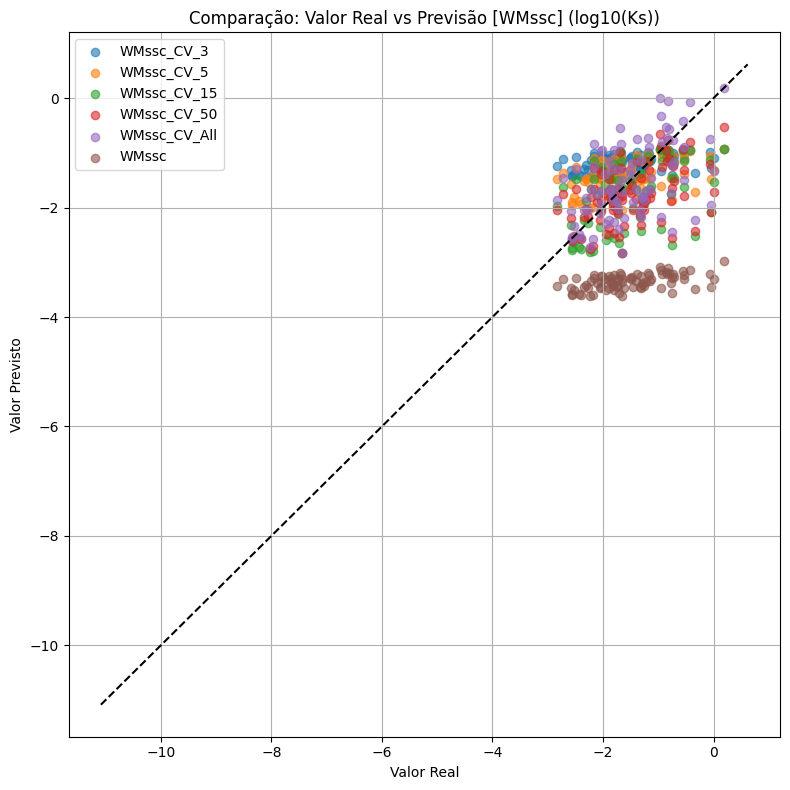

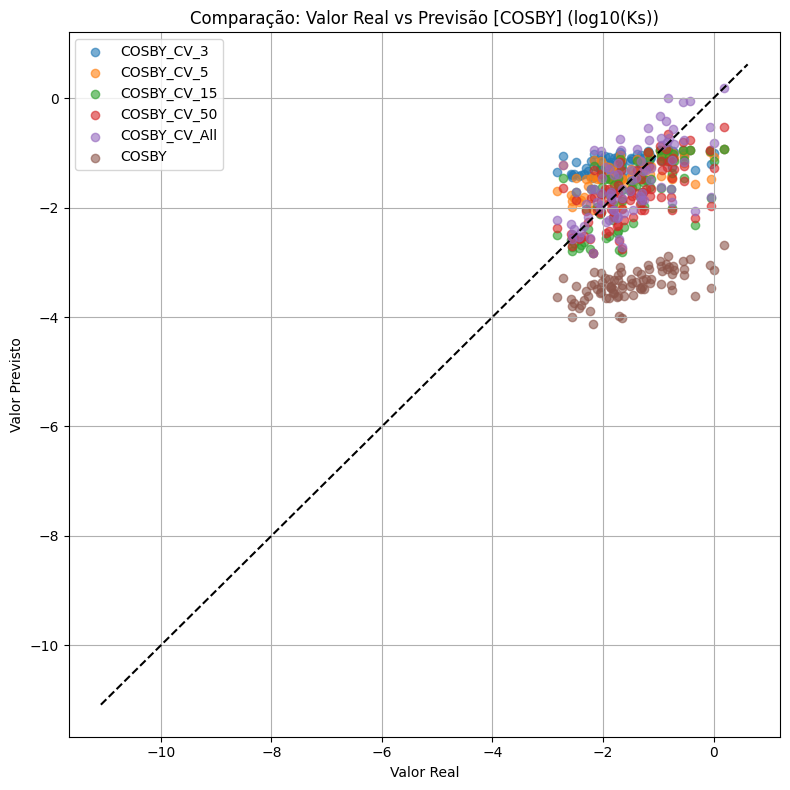

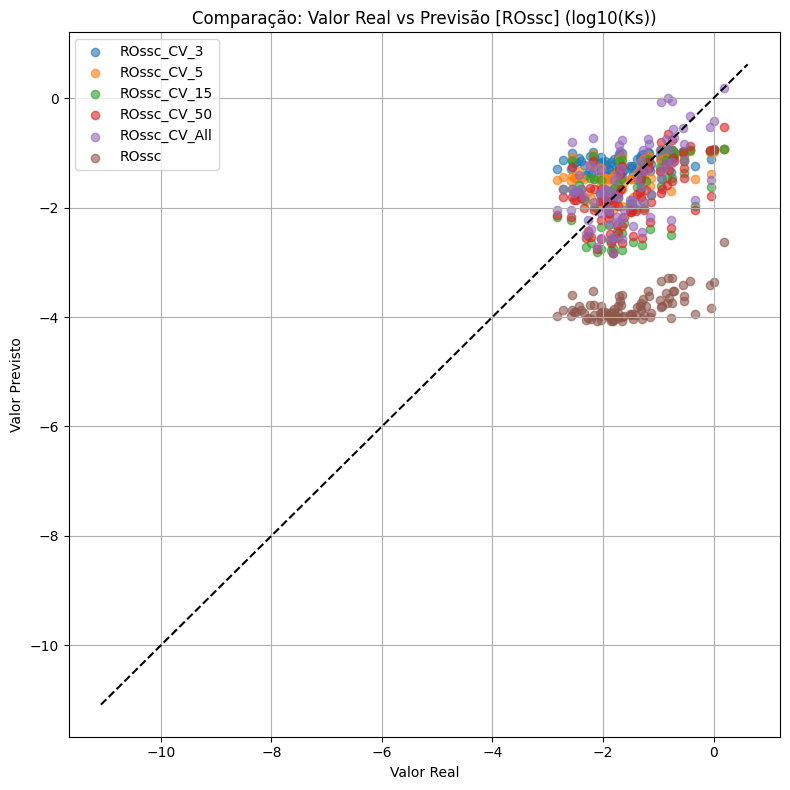

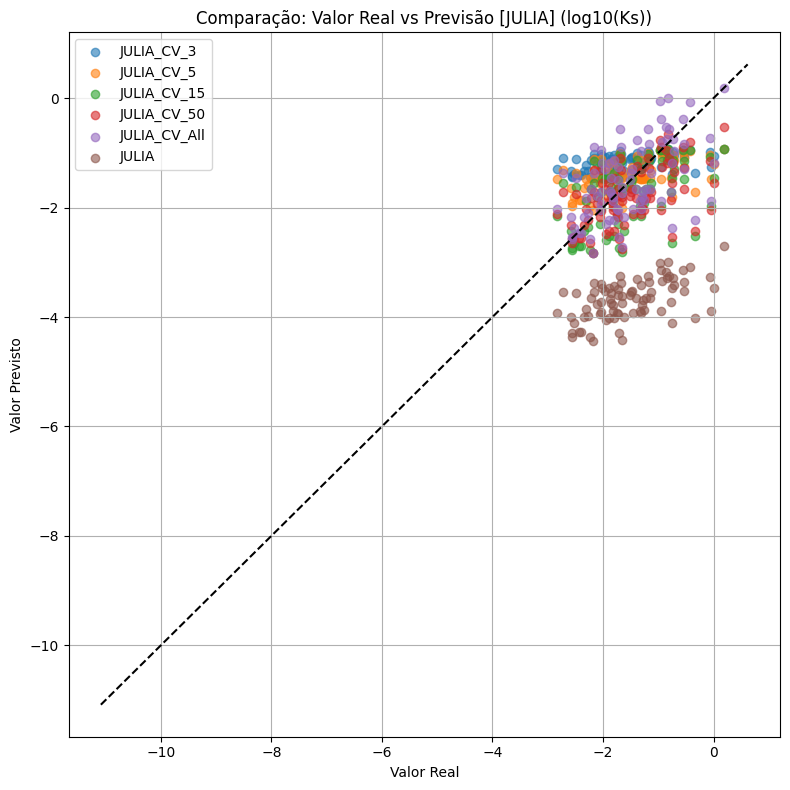

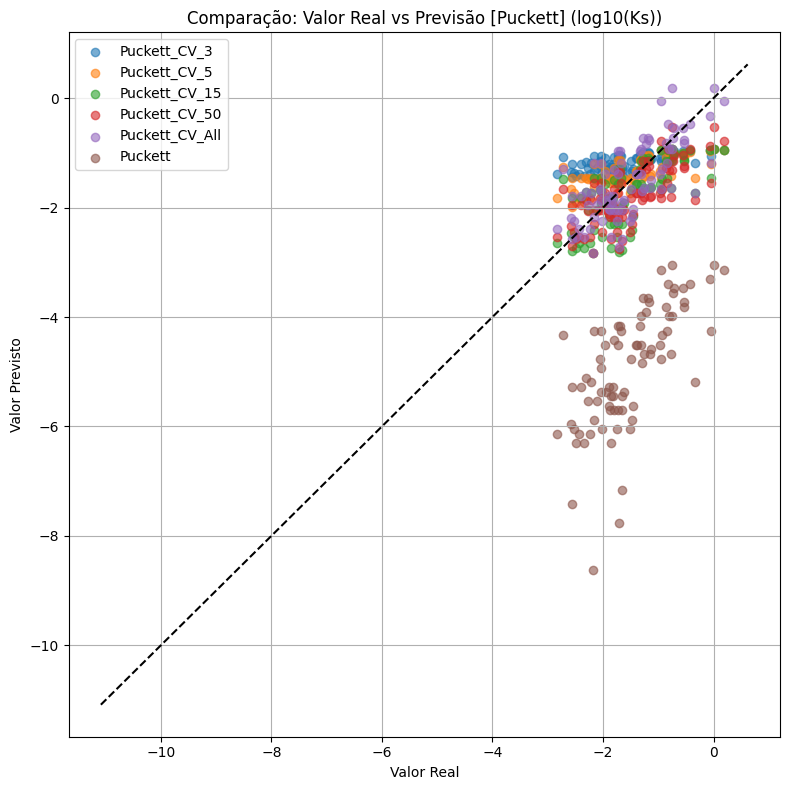

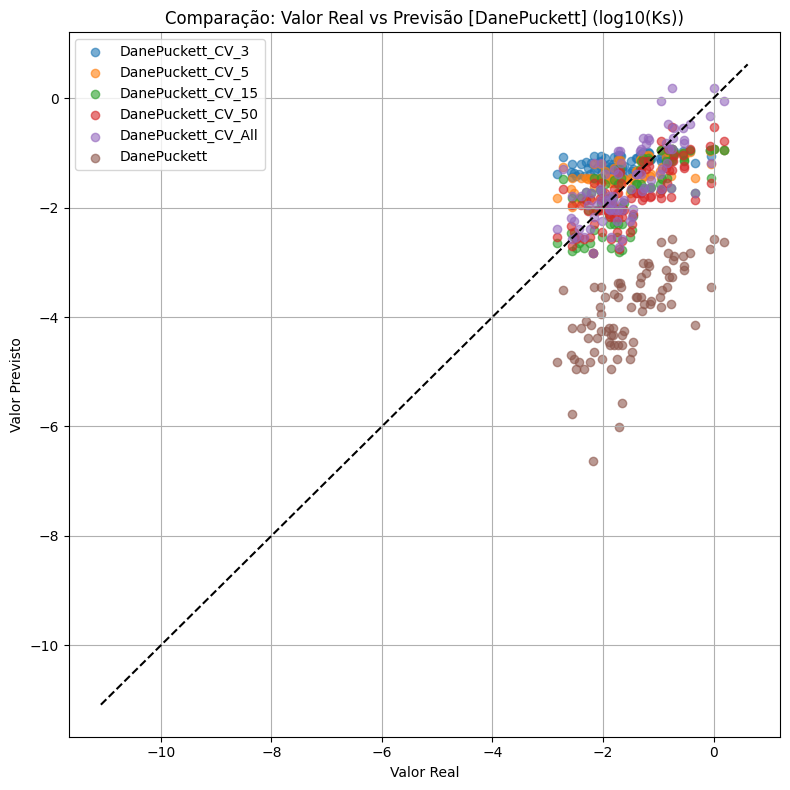

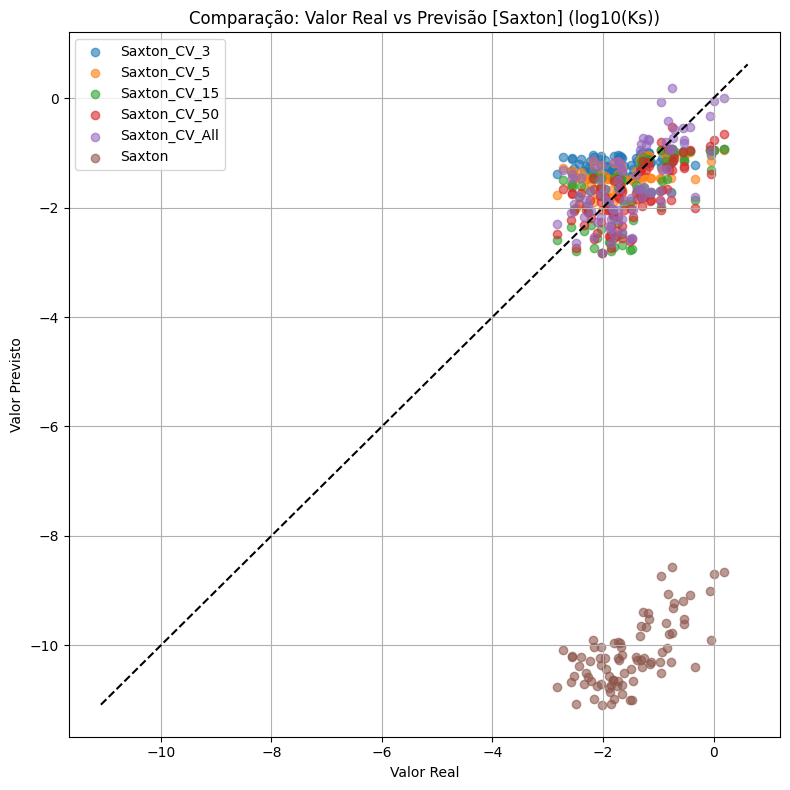

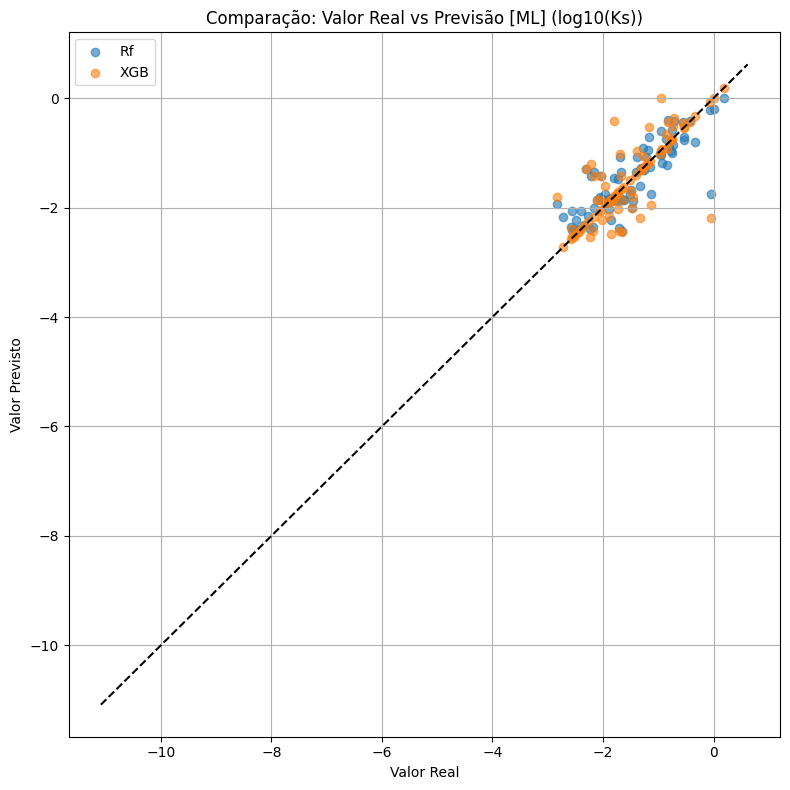

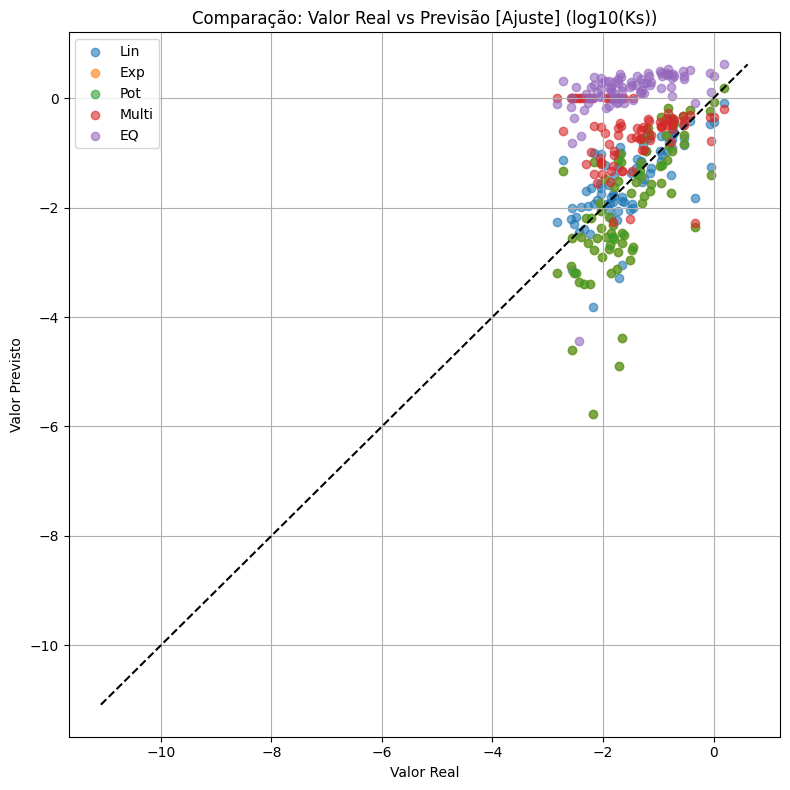

In [38]:
# Gráficos
min_val = y.min()
max_val = y.max()

# Mínimos e máximos
for key, value in KSS.items():
    for key, value in value.items():
        if key == "CVS":
            continue

        min_val = min(min_val, value.min())
        max_val = max(max_val, value.max())


# Real vs Simulado
for name, val in KSS.items():
    plt.figure(figsize=(8, 8))
    for key, value in val.items():
        if key == "CVS":
            continue
        
        plt.scatter(y, value, alpha=0.6, label=key)
    plt.plot([min_val, max_val], [min_val, max_val], 'k--')

    # Estética
    plt.xlabel("Valor Real")
    plt.ylabel("Valor Previsto")
    plt.title(f"Comparação: Valor Real vs Previsão [{name}] (log10(Ks))")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Salvar
    plt.savefig(f"graficos/grafico_{name}.png", dpi=300)
    plt.show()

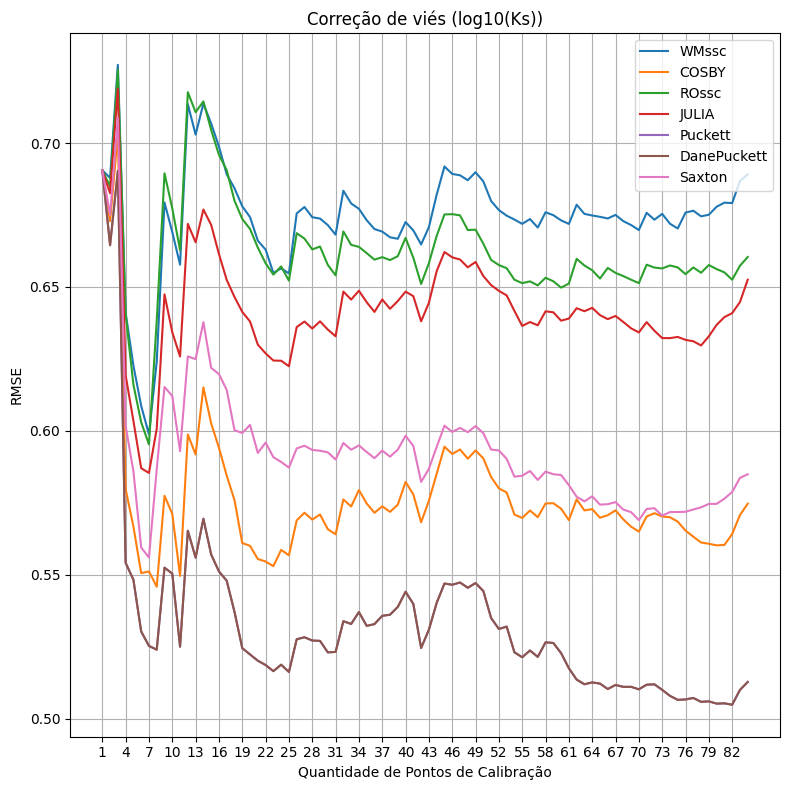

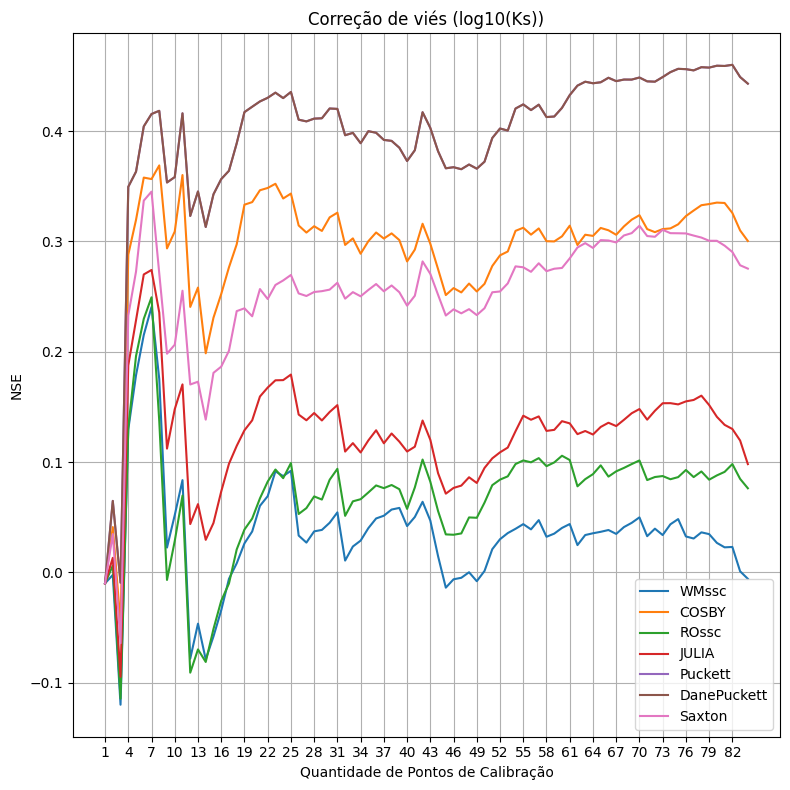

In [39]:
# NSE ou RMSE por número de pontos de calibração
params = ["RMSE", "NSE"]

x = np.arange(1, len(pontos_CV)+1)

for param in params:
    plt.figure(figsize=(8, 8))
    for name, val in KSS.items():
        if "CVS" not in val:
            continue

        values = []
        for key, value in val["CVS"].items():
            values.append(value[param])
        plt.plot(x, values, label=name)

    # Estética
    plt.xticks(np.arange(1, len(pontos_CV)+1, 3))
    # plt.xticks(np.arange(3, len(pontos_CV)+1))
    plt.xlabel("Quantidade de Pontos de Calibração")
    plt.ylabel(param)
    plt.title(f"Correção de viés (log10(Ks))")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Salvar
    plt.savefig(f"graficos/CV_NPontos_{param}.png", dpi=300)
    plt.show()